# Quantization-aware Training (QAT) for Object Detection with Model Garden

This tutorial demonstrates how to apply [quantization-aware training (QAT)](https://github.com/tensorflow/models/tree/master/official/projects/qat/vision) from a pre-trained checkpoint, export the checkpoint to a TFLite and run inference on an image, for object detection task, using [Tensorflow Model Garden](https://github.com/tensorflow/models/tree/master/official) library.

Tensorflow Model Garden contains a collection of
state-of-the-art models, implemented with TensorFlow's high-level APIs. The
implementations demonstrate the best practices for modeling, letting users to
take full advantage of TensorFlow for their research and product development.

In this tutorial, we will use MobileNetV2 backbone with RetinaNet framework as an example to walk you through the process of applying QAT. This assumes you have already trained a model using Tensorflow Model Garden.

## Install Necessary Dependencies

In [ ]:
!pip install -U tf-models-nightly

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.5 MB 6.6 MB/s 
     |████████████████████████████████| 118 kB 42.8 MB/s 
     |████████████████████████████████| 5.9 MB 24.9 MB/s 
     |████████████████████████████████| 238 kB 47.7 MB/s 
     |████████████████████████████████| 43 kB 1.6 MB/s 
     |████████████████████████████████| 1.1 MB 42.0 MB/s 
     |████████████████████████████████| 557.8 MB 8.3 kB/s 
     |████████████████████████████████| 352 kB 53.7 MB/s 
     |████████████████████████████████| 662 kB 58.0 MB/s 
     |████████████████████████████████| 1.3 MB 72.4 MB/s 
     |████████████████████████████████| 1.7 MB 50.2 MB/s 
     |████████████████████████████████| 439 kB 59.8 MB/s 
     |████████████████████████████████| 5.7 MB 26.0 MB/s 
  Created wheel for seqeval: filename=seqeval-1.2.2-py3-none-any.whl size=16179 sha256=68dce998c3a0c033d5ad8dee4c0773f4f0caf8c6aed075f786b23a2a8f39b3

## Import libraries

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image

from six import BytesIO
from IPython import display
from urllib.request import urlopen

import numpy as np
import tensorflow as tf

import absl.logging
absl.logging.set_verbosity(absl.logging.ERROR)
tf.get_logger().setLevel(absl.logging.ERROR)

## Download Pretrained Model
The model uses the implementation from the TensorFlow Model Garden GitHub repository, and achieves 23.3 mAP on COCO validation set. It uses a MobileNetV2 backbone and RetinaNet decoder on a 256x256 input image.

In [ ]:
! curl https://storage.googleapis.com/tf_model_garden/vision/qat/mobilenetv2_ssd_coco/mobilenetv2_ssd_i256_ckpt.tar.gz --output model.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 18.8M  100 18.8M    0     0  32.4M      0 --:--:-- --:--:-- --:--:-- 32.4M


In [ ]:
# Extract pretrained checkpoint.
! tar -xvzf model.tar.gz

mobilenetv2_ssd_i256_ckpt/
mobilenetv2_ssd_i256_ckpt/ckpt-277200.index
mobilenetv2_ssd_i256_ckpt/ckpt-277200.data-00000-of-00001


## Launch QAT Training

You can follow the [training guideline](https://github.com/tensorflow/models/tree/master/official/projects/qat/vision#training) to start QAT training using the pretrained checkpoint.

## Export Model

After QAT training completes, we can export a SavedModel and convert it to a TFLite model. For demonstration purpose only, we download a QAT trained model checkpoint and work on it.

In [ ]:
! curl https://storage.googleapis.com/tf_model_garden/vision/qat/mobilenetv2_ssd_coco/mobilenetv2_ssd_i256_qat_ckpt.tar.gz --output model_qat.tar.gz
! tar -xvzf model_qat.tar.gz

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 9822k  100 9822k    0     0  27.0M      0 --:--:-- --:--:-- --:--:-- 27.0M
mobilenetv2_ssd_i256_qat_ckpt/
mobilenetv2_ssd_i256_qat_ckpt/ckpt-1.data-00000-of-00001
mobilenetv2_ssd_i256_qat_ckpt/checkpoint
mobilenetv2_ssd_i256_qat_ckpt/ckpt-1.index


In [ ]:
! curl https://raw.githubusercontent.com/tensorflow/models/master/official/projects/qat/vision/configs/experiments/retinanet/coco_mobilenetv2_qat_tpu_e2e.yaml --output params.yaml

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  1836  100  1836    0     0   8784      0 --:--:-- --:--:-- --:--:--  8784


In [ ]:
# Model export and convert.
# First export a SavedModel. Make sure batch_size=1 and input_type=tflite.
! python3 /usr/local/lib/python3.8/dist-packages/official/projects/qat/vision/serving/export_saved_model.py --experiment=retinanet_mobile_coco_qat --export_dir=${PWD}/mobilenetv2_ssd_i256_qat_savedmodel --checkpoint_path=${PWD}/mobilenetv2_ssd_i256_qat_ckpt --batch_size=1 --input_type=tflite --input_image_size=256,256 --config_file=${PWD}/params.yaml --params_override="task.quantization.pretrained_original_checkpoint='${PWD}/mobilenetv2_ssd_i256_ckpt/ckpt-277200'"

# Convert the SavedModel to TFLite
! python3 /usr/local/lib/python3.8/dist-packages/official/projects/qat/vision/serving/export_tflite.py --experiment=retinanet_mobile_coco_qat --saved_model_dir=${PWD}/mobilenetv2_ssd_i256_qat_savedmodel/saved_model --tflite_path=${PWD}/mobilenetv2_ssd_i256_qat_tflite --config_file=${PWD}/params.yaml --quant_type=qat

2022-12-21 18:12:44.763114: E tensorflow/tsl/lib/monitoring/collection_registry.cc:81] Cannot register 2 metrics with the same name: /tensorflow/core/bfc_allocator_delay
2022-12-21 18:12:45.870254: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer.so.8'; dlerror: libnvinfer.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 18:12:45.870397: W tensorflow/tsl/platform/default/dso_loader.cc:66] Could not load dynamic library 'libnvinfer_plugin.so.8'; dlerror: libnvinfer_plugin.so.8: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/nvidia/lib:/usr/local/nvidia/lib64
2022-12-21 18:12:45.870421: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nvidia GPU with TensorRT, please make sure the missing libraries mentioned above are installed p

## Run Inference

Now we will show how to use the converted TFLite model to do inference and obtain detection results. We provide our converted TFLite model that can be directly used for this.

In [ ]:
# First download the TFLite model.
! curl https://storage.googleapis.com/tf_model_garden/vision/qat/mobilenetv2_ssd_coco/model_int8_qat.tflite --output model.tflite

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 3386k  100 3386k    0     0  7329k      0 --:--:-- --:--:-- --:--:-- 7329k


In [ ]:
# Defines helper function to download sample image.
def load_image_into_numpy_array(path, height, width):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (height, width, 3)
  """
  image = None
  if(path.startswith('http')):
    response = urlopen(path)
    image_data = response.read()
    image_data = BytesIO(image_data)
    image = Image.open(image_data)
  else:
    image_data = tf.io.gfile.GFile(path, 'rb').read()
    image = Image.open(BytesIO(image_data))

  (im_width, im_height) = image.size
  image = image.resize((height, width))

  image = np.array(image.getdata()).reshape(
      (1, height, width, 3)).astype(np.uint8)

  return image

### Download a Sample Image

In [ ]:
image_path = "https://djl.ai/examples/src/test/resources/dog_bike_car.jpg"
image_array = load_image_into_numpy_array(image_path, 256, 256)
image_array.shape

(1, 256, 256, 3)

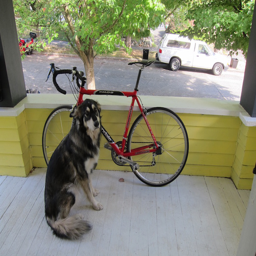

In [ ]:
Image.fromarray(image_array[0])

### Run Inference on Sample Image

In [ ]:
# Load TFLite model.
tflite_path = 'model.tflite'

with tf.io.gfile.GFile(tflite_path, 'rb') as f:
  tflite_model = f.read()

interpreter = tf.lite.Interpreter(model_content=tflite_model)
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
interpreter.set_tensor(input_details[0]['index'], image_array)

interpreter.invoke()

# The function `get_tensor()` returns a copy of the tensor data.
# Use `tensor()` in order to get a pointer to the tensor.
outputs = []
for i in range(len(output_details)):
  outputs.append(interpreter.get_tensor(output_details[i]['index']))

In [ ]:
# The final outputs is a list of [detection_boxes, num_detections, detection_scores, detection_classes, image_info].
outputs

[array([[[ 1.06062141e+02,  3.99226303e+01,  2.37835205e+02,
           1.03872078e+02],
         [ 3.33423462e+01,  1.52555298e+02,  7.61054840e+01,
           2.30757751e+02],
         [ 5.80201950e+01,  5.14244308e+01,  1.93264526e+02,
           1.90765381e+02],
         [ 3.17780743e+01,  1.97641087e+01,  5.62219238e+01,
           3.72487183e+01],
         [ 3.46833572e+01,  1.89357872e+01,  5.47490005e+01,
           2.96583672e+01],
         [ 4.58791046e+01,  1.97192001e+01,  2.30809067e+02,
           2.28094421e+02],
         [ 7.44852142e+01,  3.73519745e+01,  2.39239090e+02,
           1.48372314e+02],
         [ 4.89471016e+01,  2.19980789e+02,  6.96205444e+01,
           2.38883926e+02],
         [ 6.08561096e+01,  4.66774597e+01,  9.56913452e+01,
           8.47750854e+01],
         [ 5.58034134e+00,  5.37203522e+01,  9.11066132e+01,
           1.00488342e+02],
         [ 3.71521416e+01,  2.12559471e+01,  4.48743706e+01,
           2.73382072e+01],
         [ 1.20761276

### Visualize Detection Outputs

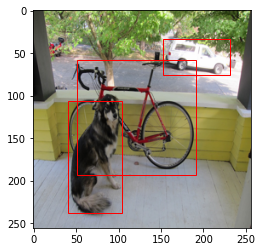

In [ ]:
plt.imshow(Image.fromarray(image_array[0]))

scores = outputs[2]
num_detection = outputs[1]
boxes = outputs[0]
classes = outputs[3]

# We only show boxes that have detection score larger than 0.5.
threshold = 0.5

for i in range(int(num_detection[0])):
  if scores[0, i] > threshold:
    ax = plt.gca()
    rect = patches.Rectangle((boxes[0, i, 1], boxes[0, i, 0]), boxes[0, i, 3] - boxes[0, i, 1], boxes[0, i, 2] - boxes[0, i, 0], linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)